# Combining PCTA, WCDT and GSE221601 datasets for prostate cancer

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import sys
from pathlib import Path
import rpy2.robjects as ro
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
from r_wrappers.sva import combat_seq
from r_wrappers.utils import rpy2_df_to_pd_df, pd_df_to_rpy2_df
from r_wrappers.deseq2 import vst_transform

### Global Variables

In [5]:
PCTA_WCDT_ROOT: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT")
GSE221601_ROOT: Path = Path("/media/ssd/Perez/storage/GSE221601")
PCTA_WCDT_GSE221601_ROOT: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601")
PCTA_WCDT_GSE221601_ROOT.mkdir(exist_ok=True, parents=True)
(PCTA_WCDT_GSE221601_ROOT / "data").mkdir(exist_ok=True, parents=True)

## 1. Load and merge annotation data from all datasets

### 1.1. TCGA-PRAD + SU2C-PCF

In [6]:
annot_df_pcta_wcdt = pd.read_csv(
    PCTA_WCDT_ROOT / "data" / "samples_annotation.csv",
    index_col=0,
)
display(annot_df_pcta_wcdt.head())

,dataset,patient_id,sample_id,sample_type,ethnicity,diagnosis_age,biopsy_age,psa_level_________________________(at_diagonosis_for_crpc),gleason_score,gleason_score_of_initial_primary_tumor,...,is_tumor,affection,sex,race,file_id,file_name,data_category,data_type,project_id,sample_id.1
entry_1,GSE120795,SRR7961228,SRR7961228,norm,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_897,PRJEB21092,V4,1065RP-LN,met,NaN,NaN,51.0,43.00,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_819,PRJEB21092,V20,1135RP,prim,NaN,NaN,73.0,11.15,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_820,PRJEB21092,V21,703LP,prim,NaN,NaN,71.0,0.86,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entry_822,PRJEB21092,V22,482RT,prim,NaN,NaN,65.0,15.00,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
annot_df_pcta_wcdt["sample_type"].value_counts()

sample_type
prim         662
met          336
norm         174
met_neuro     19
Name: count, dtype: int64

In [8]:
annot_df_pcta_wcdt = annot_df_pcta_wcdt[
    annot_df_pcta_wcdt["sample_type"].isin(("norm", "prim", "met"))
]
annot_df_pcta_wcdt["sample_type"] = annot_df_pcta_wcdt["sample_type"].replace(
    "met", "mcrpc"
)
annot_df_pcta_wcdt["sample_type"].value_counts()

sample_type
prim     662
mcrpc    336
norm     174
Name: count, dtype: int64

### 1.2. GSE221601

In [9]:
annot_df_gse221601 = pd.read_csv(
    GSE221601_ROOT / "data" / "samples_annotation.csv", index_col=0
)
display(annot_df_gse221601.head())

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,cluster_subtype
Run,,,,,,,,,,,,,,,,,,,,,
SRR22868605,RNA-Seq,200,3118990600,PRJNA915071,SAMN32372324,1397896683,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:38:00Z,1,GSM6890182,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868606,RNA-Seq,200,2437501200,PRJNA915071,SAMN32372325,1089843290,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:25:00Z,1,GSM6890181,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868607,RNA-Seq,200,4465919800,PRJNA915071,SAMN32372326,1924590452,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:34:00Z,1,GSM6890180,Prostate cancer,SRP414492,Prostate cancer,NaN
SRR22868608,RNA-Seq,200,6239105400,PRJNA915071,SAMN32372327,2739084770,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:38:00Z,1,GSM6890179,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868609,RNA-Seq,200,7531102000,PRJNA915071,SAMN32372328,3294991515,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:41:00Z,1,GSM6890178,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low


In [10]:
annot_df_gse221601["release_year"] = pd.to_datetime(
    annot_df_gse221601["ReleaseDate"]
).dt.year

In [11]:
annot_df_gse221601.iloc[0, :]

Assay Type                                                      RNA-Seq
AvgSpotLen                                                          200
Bases                                                        3118990600
BioProject                                                  PRJNA915071
BioSample                                                  SAMN32372324
Bytes                                                        1397896683
Center Name           PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...
Consent                                                          public
DATASTORE filetype                                     fastq,run.zq,sra
DATASTORE provider                                           gs,ncbi,s3
DATASTORE region                   gs.us-east1,ncbi.public,s3.us-east-1
disease_state                                                     Tumor
Experiment                                                  SRX18827362
Instrument                                          Illumina HiS

### 1.3. Combine all annotation data into a common format

In [12]:
annot_df = pd.DataFrame(
    columns=["sample_id", "patient_id", "sample_type", "dataset", "library_type"]
)

In [13]:
annot_df["sample_id"] = (
    annot_df_pcta_wcdt.index.tolist() + annot_df_gse221601.index.tolist()
)
annot_df["patient_id"] = (
    annot_df_pcta_wcdt["patient_id"].tolist() + annot_df_gse221601["BioSample"].tolist()
)
annot_df["sample_type"] = (
    annot_df_pcta_wcdt["sample_type"].tolist() + ["hspc"] * annot_df_gse221601.shape[0]
)
annot_df["dataset"] = (
    annot_df_pcta_wcdt["dataset"].tolist() + ["GSE221601"] * annot_df_gse221601.shape[0]
)
annot_df["library_type"] = (
    annot_df_pcta_wcdt["library_type"].tolist()
    + ["poly_a"] * annot_df_gse221601.shape[0]
)
# We assume GSE221601 used PolyA because raw samples contained many PolyA adapters

In [14]:
annot_df.sort_values(by="sample_type", ascending=False).to_csv(
    PCTA_WCDT_GSE221601_ROOT / "data" / "samples_annotation.csv", index=False
)

In [15]:
pd.read_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "samples_annotation.csv", index_col=0)

,patient_id,sample_type,dataset,library_type
sample_id,,,,
entry_357,TCGA-G9-6342-01,prim,TCGA,poly_a
entry_521,TCGA-EJ-A8FP-01,prim,TCGA,poly_a
entry_523,TCGA-KK-A8I7-01,prim,TCGA,poly_a
entry_524,TCGA-KK-A8IG-01,prim,TCGA,poly_a
entry_525,TCGA-KK-A8IH-01,prim,TCGA,poly_a
...,...,...,...,...
SRR22868629,SAMN32372348,hspc,GSE221601,poly_a
SRR22868630,SAMN32372349,hspc,GSE221601,poly_a
SRR22868631,SAMN32372350,hspc,GSE221601,poly_a


## 2. Load and merge RNA-Seq expression data from all datasets

### 2.1. PCTA + WCDT

In [16]:
pcta_wcdt_raw_counts = pd.read_csv(
    PCTA_WCDT_ROOT / "data" / "raw_counts.csv", index_col=0
)

### 2.1. TCGA-PRAD + SU2C-PCF

In [17]:
gse221601_counts = []
for sample_counts in (GSE221601_ROOT / "data" / "star_counts").glob("*.tsv"):
    star_count = (
        pd.read_csv(sample_counts, sep="\t", index_col=0, header=None, names=["count"])
        .squeeze("columns")
        .rename(sample_counts.stem)
    )
    gse221601_counts.append(star_count)

In [18]:
gse221601_raw_counts = pd.concat(gse221601_counts, axis=1)
gse221601_raw_counts.to_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts.csv")

In [19]:
counts_df = pd.concat(
    [
        pcta_wcdt_raw_counts,
        gse221601_raw_counts,
    ],
    axis=1,
).dropna(axis=0)
counts_df = counts_df.loc[counts_df.mean(axis=1) > 10]
counts_df = counts_df[counts_df.columns.intersection(annot_df["sample_id"])]
counts_df.to_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts.csv", index=True)

In [20]:
pd.read_csv(PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts.csv", index_col=0)

,entry_1,entry_2,entry_3,entry_4,entry_5,entry_6,entry_7,entry_8,entry_9,entry_10,...,SRR22868655,SRR22868656,SRR22868657,SRR22868658,SRR22868659,SRR22868660,SRR22868661,SRR22868662,SRR22868663,SRR22868664
ENSG00000227232,0.0,0.0,3.0,0.0,0.0,0.0,100.0,126.0,570.0,501.0,...,104.0,201.0,202.0,162.0,366.0,616.0,644.0,373.0,733.0,388.0
ENSG00000268903,4.0,6.0,7.0,23.0,6.0,7.0,65.0,322.0,188.0,288.0,...,91.0,15.0,37.0,7.0,32.0,94.0,110.0,31.0,38.0,111.0
ENSG00000269981,3.0,3.0,7.0,19.0,1.0,14.0,52.0,231.0,58.0,158.0,...,201.0,22.0,52.0,16.0,97.0,232.0,322.0,70.0,74.0,394.0
ENSG00000279457,2.0,4.0,6.0,3.0,1.0,24.0,122.0,213.0,674.0,1135.0,...,1633.0,2418.0,2095.0,1792.0,3063.0,4322.0,2514.0,2486.0,5624.0,2020.0
ENSG00000228463,0.0,0.0,0.0,1.0,0.0,7.0,50.0,33.0,16.0,48.0,...,10.0,0.0,2.0,1.0,8.0,1.0,10.0,4.0,4.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198886,115164.0,60110.0,40226.0,1284268.0,1775463.0,186549.0,416388.0,328953.0,5088010.0,1874721.0,...,983.0,684.0,529.0,3774.0,433.0,667.0,930.0,619.0,1740.0,1734.0
ENSG00000198786,59658.0,39106.0,22029.0,702062.0,1733955.0,93606.0,57756.0,43029.0,450199.0,257336.0,...,599.0,481.0,374.0,1938.0,433.0,483.0,643.0,409.0,1028.0,1066.0
ENSG00000198695,15574.0,12190.0,5739.0,251648.0,552938.0,23346.0,10075.0,8282.0,88645.0,40438.0,...,180.0,104.0,115.0,506.0,115.0,125.0,172.0,99.0,272.0,351.0
ENSG00000198727,60039.0,38387.0,28159.0,754732.0,1398135.0,102360.0,183753.0,149202.0,1666819.0,974743.0,...,317.0,308.0,225.0,1426.0,192.0,307.0,333.0,193.0,596.0,619.0


## 3. Perform batch correction

### 3.1. PCA of unprocessed data

In [21]:
vst_df = rpy2_df_to_pd_df(
    vst_transform(
        ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df))
    )
)

R[write to console]: converting counts to integer mode



In [22]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vst_df.T)

pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"], index=vst_df.columns)
pca_df["sample_type"] = (
    annot_df.set_index("sample_id").loc[vst_df.columns, "sample_type"].values
)
explained_variance = pca.explained_variance_ratio_

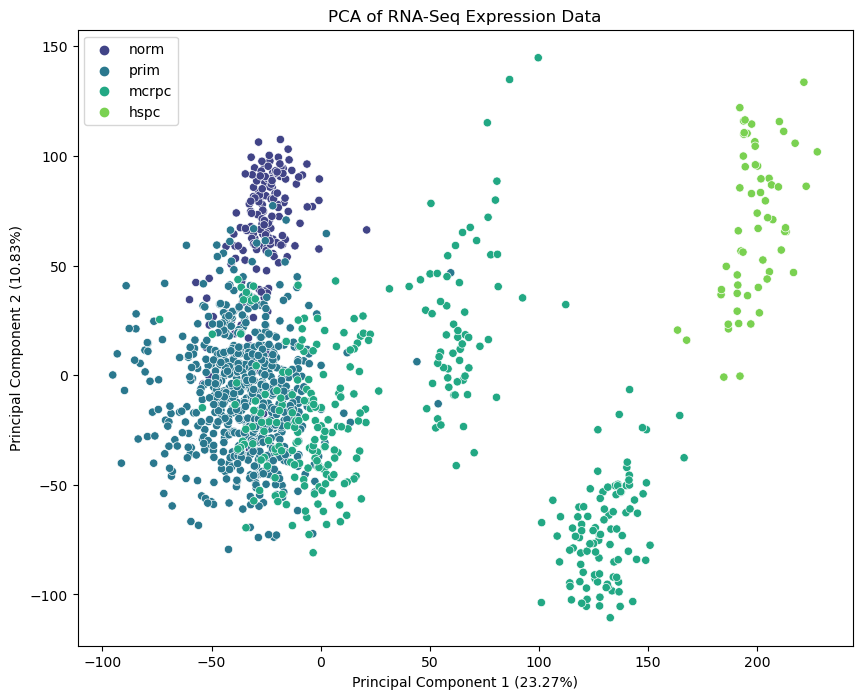

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="sample_type", data=pca_df, palette="viridis")
plt.title("PCA of RNA-Seq Expression Data")
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
plt.legend(loc="best")
plt.show()

### 3.2. ComBat batch correction

In [25]:
annot_df.groupby(["dataset", "library_type", "sample_type"]).count()

sample_id  patient_id
dataset     library_type   sample_type                       
GSE118435   poly_a         mcrpc               41          41
GSE120741   poly_a         prim                91          91
GSE120795   total_rna      norm                 6           6
GSE126078   poly_a         mcrpc               55          55
GSE221601   poly_a         hspc                60          60
GTEX        total_rna      norm               116         116
PRJEB21092  total_rna      mcrpc                5           5
                           prim                43          43
PRJNA477449 poly_a         prim                31          31
TCGA        poly_a         norm                52          52
                           prim               497         497
WCDT        total_rna      mcrpc               99           0
phs000673   hybrid_capture mcrpc               36          36
phs000909   poly_a         mcrpc               27          27
phs000915   hybrid_capture mcrpc               15          15
            poly_a         mcrpc               58          58

In [26]:
label_encoder = LabelEncoder()

annot_df["library_type_encoded"] = label_encoder.fit_transform(annot_df["library_type"])

In [27]:
counts_df_batch_corrected = combat_seq(
    counts_df=counts_df,
    batch=annot_df["library_type_encoded"].tolist(),
    group="sample_type",
    # shrink=True,
    # shrink_disp=True,
)
counts_df_batch_corrected.to_csv(
    PCTA_WCDT_GSE221601_ROOT / "data" / "raw_counts_batch_corrected.csv",
    index=True,
)

Found 3 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


### 3.3. PCA of batch-corrected data

In [28]:
vst_df_batch_corrected = rpy2_df_to_pd_df(
    vst_transform(ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df_batch_corrected)))
)


In [29]:
pca_corrected = PCA(n_components=2)
pca_result_corrected = pca_corrected.fit_transform(vst_df_batch_corrected.T)

pca_df_corrected = pd.DataFrame(
    data=pca_result_corrected,
    columns=["PC1", "PC2"],
    index=vst_df_batch_corrected.columns,
)
pca_df_corrected["sample_type"] = (
    annot_df.set_index("sample_id")
    .loc[vst_df_batch_corrected.columns, "sample_type"]
    .values
)
explained_variance = pca_corrected.explained_variance_ratio_

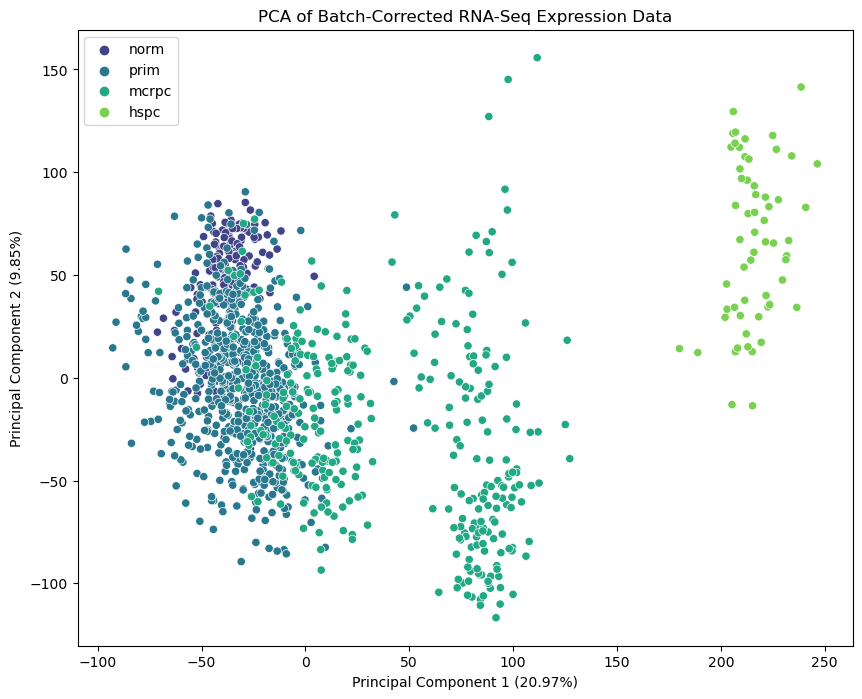

In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", y="PC2", hue="sample_type", data=pca_df_corrected, palette="viridis"
)
plt.title("PCA of Batch-Corrected RNA-Seq Expression Data")
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
plt.legend(loc="best")
plt.show()